# **Análise de Sentimentos - Omicron Rising**

**Objetivo:**
* Analisar o sentimento da opinião pública sobre a ascensão da variante ômicron;

### **1. Introdução**

<p align="justify">
Este projeto de Machine Learning propõe uma análise abrangente do sentimento da opinião pública em relação à emergência e ascensão da variante Ômicron do vírus SARS-CoV-2.

<p align="justify">
Por meio da aplicação de técnicas de Processamento de Linguagem Natural (PLN) e aprendizado de máquina, buscamos extrair insights significativos a partir de dados textuais. A análise do sentimento permitirá categorizar as opiniões públicas em termos de positividade, neutralidade ou negatividade, fornecendo uma visão holística das reações à Ômicron.

In [ ]:
# Carregando bibliotecas

import re
import nltk
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
# Realizando download das stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Realizando download do vader

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# Carregando base de dados

dados = pd.read_csv('/content/drive/MyDrive/Ciência de Dados com Python/Projetos/Dados/omicron_rising_dataset.csv')

## Fonte de Dados: Kaggle

In [ ]:
# Visualizando dados

dados.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1491840066506743820,Nathan Joyner,"Los Angeles, CA",Global Venture Captial and Private Equity/Busi...,2015-05-18 20:52:29,49,11,803,False,2022-02-10 18:22:43,Daily US Confirmed Covid Cases by County For M...,NaN,smcapplication,0,0,False
1,1491839660674490371,Gatherer Thompson,Corporate,I'm with the people who are with everyone. A s...,2009-05-10 23:01:22,639,1931,46369,False,2022-02-10 18:21:06,@Yascha_Mounk #CDC says number of fully #vacci...,"['CDC', 'vaccinated', 'Omicron', 'hospital']",Twitter Web App,0,0,False
2,1491839607368867842,Nathan Joyner,"Los Angeles, CA",Global Venture Captial and Private Equity/Busi...,2015-05-18 20:52:29,49,11,803,False,2022-02-10 18:20:54,Daily US Confirmed Covid Cases by County For L...,NaN,smcapplication,0,0,False
3,1491839207169351689,Nathan Joyner,"Los Angeles, CA",Global Venture Captial and Private Equity/Busi...,2015-05-18 20:52:29,49,11,803,False,2022-02-10 18:19:18,Daily US Confirmed Covid Cases by County For L...,NaN,smcapplication,2,1,False
4,1491839165608177667,Brownyard Group,"Bay Shore, NY",We offer liability coverage for the Security G...,2009-12-08 16:41:53,375,284,61,False,2022-02-10 18:19:08,With the #Beijing2022 #WinterOlympics already ...,"['Beijing2022', 'WinterOlympics', 'olympians',...",Agorapulse app,0,0,False


### **2. Análise Exporatória de Dados**

In [ ]:
# Informações sobre o dataset

dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17046 entries, 0 to 17045
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                17046 non-null  int64 
 1   user_name         17046 non-null  object
 2   user_location     13434 non-null  object
 3   user_description  15716 non-null  object
 4   user_created      17046 non-null  object
 5   user_followers    17046 non-null  int64 
 6   user_friends      17046 non-null  int64 
 7   user_favourites   17046 non-null  int64 
 8   user_verified     17046 non-null  bool  
 9   date              17046 non-null  object
 10  text              17046 non-null  object
 11  hashtags          10219 non-null  object
 12  source            17046 non-null  object
 13  retweets          17046 non-null  int64 
 14  favorites         17046 non-null  int64 
 15  is_retweet        17046 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.9+ MB


In [ ]:
# Verificando a existência de valores faltantes

dados.isnull().sum()

id                     0
user_name              0
user_location       3612
user_description    1330
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            6827
source                 0
retweets               0
favorites              0
is_retweet             0
dtype: int64

In [ ]:
# Números de usuários verificados

dados['user_verified'].value_counts()

False    15220
True      1826
Name: user_verified, dtype: int64

### **3. Pré-Processamento de Dados**

In [ ]:
# Removendo dados faltantes

dados = dados.dropna()

In [ ]:
# Verificando se ainda existe dados faltantes

dados.isnull().sum()

id                  0
user_name           0
user_location       0
user_description    0
user_created        0
user_followers      0
user_friends        0
user_favourites     0
user_verified       0
date                0
text                0
hashtags            0
source              0
retweets            0
favorites           0
is_retweet          0
dtype: int64

In [ ]:
# Instânciando objetos

## Stemmer
stemmer = nltk.SnowballStemmer("english")

## Stopwords
stopword = set(stopwords.words('english'))

In [ ]:
# Criando função para limpeza do texto

def clean(texto):
    texto = str(texto).lower()
    texto = re.sub('\[.*?\]', '', texto)
    texto = re.sub('https?://\S+|www\.\S+', '', texto)
    texto = re.sub('<.*?>+', '', texto)
    texto = re.sub('[%s]' % re.escape(string.punctuation), '', texto)
    texto = re.sub('\n', '', texto)
    texto = re.sub('\w*\d\w*', '', texto)
    texto = [word for word in texto.split(' ') if word not in stopword]
    texto = " ".join(texto)
    texto = [stemmer.stem(word) for word in texto.split(' ')]
    texto = " ".join(texto)
    return texto

In [ ]:
# Aplicando aos dados

dados["text"] = dados["text"].apply(clean)

### **4. Resultados**

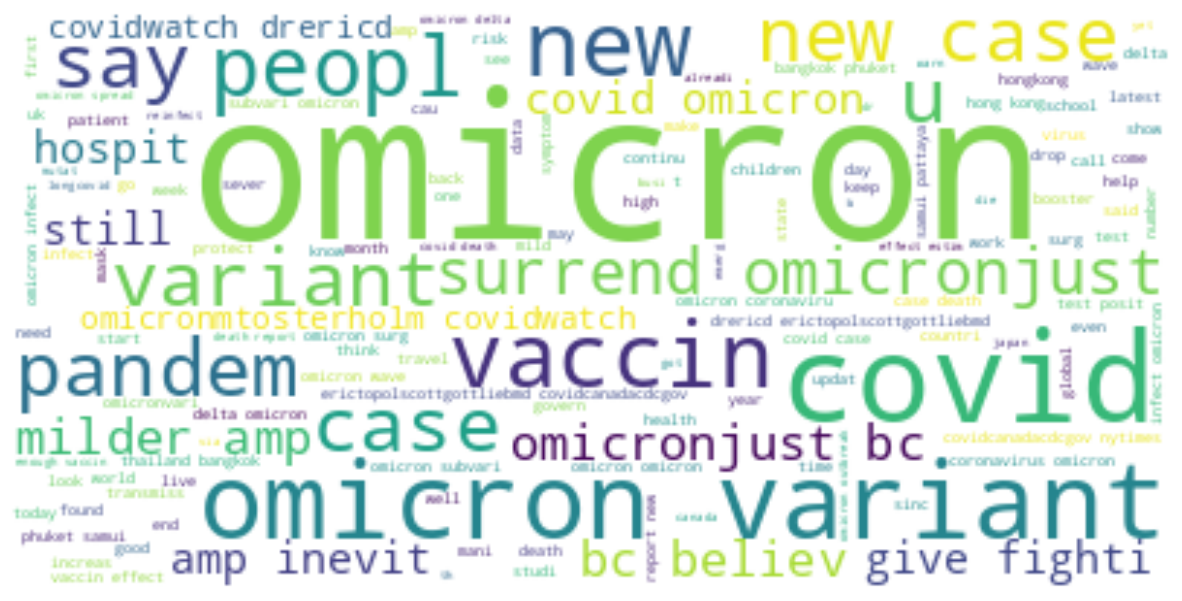

In [ ]:
# Criando nuvem de palavras: analisando tweets

## Concatenando textos
texto = " ".join(i for i in dados.text)

## Selecionando Stopwords
stopwords = set(STOPWORDS)

## Configurando nuvem de palavras
wordcloud = WordCloud(stopwords = stopwords,
                      background_color = "white").generate(texto)

## Plotando nuvem
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show();

In [ ]:
# Analisando sentimentos dos tweets

## Instânciando objeto
sentimentos = SentimentIntensityAnalyzer()

## Adicionando colunas ao dataset com informações sobre os sentimentos
dados["Positive"] = [sentimentos.polarity_scores(i)["pos"] for i in dados["text"]]
dados["Negative"] = [sentimentos.polarity_scores(i)["neg"] for i in dados["text"]]
dados["Neutral"] = [sentimentos.polarity_scores(i)["neu"] for i in dados["text"]]

## Criando novo dataset com tweets e resultados dos sentimentos
data = dados[["text", "Positive", "Negative", "Neutral"]]

In [ ]:
# Visualizando dados

data.head()

,text,Positive,Negative,Neutral
1,yaschamounk cdc say number fulli vaccin omicro...,0.126,0.0,0.874
4,winterolymp alreadi underway us olympian look...,0.000,0.0,1.000
5,doctor help discov omicron say pressur reveal ...,0.213,0.0,0.787
8,month tonga final singl doubl tappeda sickn...,0.000,0.0,1.000
11,covid pandem continu ukrain case rapid rise du...,0.000,0.0,1.000


In [ ]:
# Classificando tweets

## Criando função para classificação
def classifica_texto(row):
    if row['Positive'] > row['Negative'] and row['Positive'] > row['Neutral']:
        return 'Positivo'
    elif row['Negative'] > row['Positive'] and row['Negative'] > row['Neutral']:
        return 'Negativo'
    else:
        return 'Neutro'

In [ ]:
# Aplicando a função de classificação ao DataFrame

data['Sentimentos'] = data.apply(classifica_texto, axis = 1)

<ipython-input-18-e4315051c4fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sentimentos'] = data.apply(classifica_texto, axis = 1)


In [ ]:
# Visualizando dados

data.head()

,text,Positive,Negative,Neutral,Sentimentos
1,yaschamounk cdc say number fulli vaccin omicro...,0.126,0.0,0.874,Neutro
4,winterolymp alreadi underway us olympian look...,0.000,0.0,1.000,Neutro
5,doctor help discov omicron say pressur reveal ...,0.213,0.0,0.787,Neutro
8,month tonga final singl doubl tappeda sickn...,0.000,0.0,1.000,Neutro
11,covid pandem continu ukrain case rapid rise du...,0.000,0.0,1.000,Neutro


In [ ]:
# Realizando contagem de elementos

data["Sentimentos"].value_counts()

Neutro      7429
Negativo      84
Positivo      62
Name: Sentimentos, dtype: int64

### **5. Considerações Finais**

<p align="justify">
A análise de sentimento revelou uma predominância significativa de opiniões neutras em relação à ascensão da variante Ômicron do vírus SARS-CoV-2, com um total de 7429 observações nessa categoria. Esta predominância sugere que grande parte da opinião pública expressa uma postura equilibrada ou neutra em relação aos desenvolvimentos associados à nova variante.

<p align="justify">
Por outro lado, observou-se uma representação relativamente pequena de opiniões negativas, totalizando 84, e opiniões positivas, somando 62. Esses números indicam que, embora haja uma minoria expressando preocupações ou otimismo, a maioria das opiniões permanece em um espectro neutro.

<p align="justify">
A escassez de opiniões positivas e negativas pode refletir a complexidade e incerteza associadas à variante Ômicron, destacando a necessidade de mais pesquisas e comunicação transparente para moldar percepções e compreensão pública. A análise desses resultados destaca a importância de abordagens equilibradas e contextuais ao comunicar informações relacionadas à saúde pública, especialmente em cenários de rápida evolução.